---
format: html

title: "Global Wheat Detection - My Solution"
author: "Shai Nisan"
date: "2023-04-10"
categories: [YOLOV8, kaggle, augmentation, computer vision, vision]
description: 'My solution to the Global Wheat Detection'
image: "pic.png"
---

Install important packages

In [1]:
%%capture

!pip install imgaug

In [2]:
%%capture

!pip install pybboxes

In [3]:
%%capture

!pip install albumentations

Load important packages

In [5]:
import pandas as pd
import numpy as np
from pybboxes import BoundingBox

import shutil
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A
import os

Load the data

In [16]:
df = pd.read_csv('train.csv')

Convert the string representations of the bounding boxes in the 'bbox' column to lists of floats

In [17]:
df['bbox'] = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=','))).tolist()

In [18]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


A function that returns a list of bounding boxes from the DataFrame for a given image_id.

In [19]:
def get_bboxes(image_id):
    bboxes = []
    category_ids = []
    for idx in df[df['image_id'] == image_id].index:
        bboxes.append(df.loc[idx, 'bbox'])
    return bboxes

Augment the images in "train".

In [21]:
df_list = []

for img in df["image_id"].unique().tolist():

    img_id = img

    image = cv2.imread('train/'+ img_id + '.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    bboxes = get_bboxes(img_id)

    category_ids = np.ones(len(bboxes))

    category_id_to_name = {1: 'wheat'}

    transform = A.Compose([
        A.Flip(p=0.5),
        A.Rotate (p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Perspective (p=0.5),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

    df_aug_list = []

    for i in range(10):

        transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)

        # Filename
        filename = img_id+'_aug_'+str(i)+'.jpg'

        # Saving the image
        cv2.imwrite("augmented_images/"+filename, transformed['image'])

        # Create DataFrame for the augmented image
        df_aug = pd.DataFrame({'image_id': img_id+'_aug_'+str(i), 'bbox': transformed['bboxes']})
        df_aug_list.append(df_aug)

    # Concatenate the DataFrames for all augmented images for this image ID
    df_aug = pd.concat(df_aug_list, ignore_index=True)
    df_list.append(df_aug)

# Concatenate the DataFrames for all image IDs
df_aug_all = pd.concat(df_list, ignore_index=True)
df_aug_all.to_csv('df_aug_all.csv') 

In [22]:
df_aug_all.head()

,image_id,bbox
0,b6ab77fd7_aug_0,"(79.2015456081081, 791.7428278688525, 67.83977..."
1,b6ab77fd7_aug_0,"(706.5571621621622, 413.1419057377049, 145.164..."
2,b6ab77fd7_aug_0,"(598.8581756756757, 348.9420466188525, 92.7993..."
3,b6ab77fd7_aug_0,"(8.993153505067568, 853.2836834016393, 134.575..."
4,b6ab77fd7_aug_0,"(899.5014864864866, 778.1778944672132, 124.498..."


In [23]:
# Define a function to convert the bbox from COCO to YOLO format
def coco_to_yolo(bbox):
    try:
        coco_bbox = BoundingBox.from_coco(*bbox, image_size=(1024, 1024))
        yolo_bbox = coco_bbox.to_yolo()
        return yolo_bbox.raw_values
    except:
        pass

# Apply the function to each row in the 'bbox' column and store the results in a new column named 'yolo_bbox'
df_aug_all['yolo_bbox'] = df_aug_all['bbox'].apply(coco_to_yolo)

In [27]:
df_aug_all.head()

,image_id,bbox,yolo_bbox
0,b6ab77fd7_aug_0,"(79.2015456081081, 791.7428278688525, 67.83977...","(0.1103515625, 0.79345703125, 0.06640625, 0.04..."
1,b6ab77fd7_aug_0,"(706.5571621621622, 413.1419057377049, 145.164...","(0.76123046875, 0.4345703125, 0.1416015625, 0...."
2,b6ab77fd7_aug_0,"(598.8581756756757, 348.9420466188525, 92.7993...","(0.63037109375, 0.42578125, 0.0908203125, 0.16..."
3,b6ab77fd7_aug_0,"(8.993153505067568, 853.2836834016393, 134.575...","(0.07470703125, 0.8916015625, 0.1318359375, 0...."
4,b6ab77fd7_aug_0,"(899.5014864864866, 778.1778944672132, 124.498...","(0.939453125, 0.8203125, 0.12109375, 0.12109375)"


In [28]:
df_aug_all.isnull().sum()

image_id       0
bbox           0
yolo_bbox    956
dtype: int64

At this stage we will skip boxes that were cut out of the image boundries during the augmentation.

We then group df_without_na by image_id, and for each group, we'll create a text file in the "augmented_images/labels/" directory with the same name as the image_id, and write the bboxes to it.

In [31]:
df_without_na = df_aug_all.dropna()


grouped = df_without_na.groupby("image_id")

for name, group in grouped:
    # Create a text file with the same name as the image_id in the "augmented_images/labels/" directory
    filename = "augmented_images/labels/" + name + ".txt"
    
    # Get the bounding boxes for this image
    boxes = group["yolo_bbox"].tolist()
    
    # Open the file and write the bounding boxes to it
    with open(filename, "w") as f:
        for box in boxes:
            # Convert the tuple to a string and prepend "0" to the box values, then write them to the file
            box_str = " ".join(str(coord) for coord in box)
            line = "0 " + box_str + "\n"
            f.write(line)


Now we can set up a directory structure for the YOLO model: we split a set of images and corresponding labels into train, test, and validation sets, and copy them to their respective directories while preserving the structure of the original files.

In [35]:
# Set the root directory
root_dir = "shaiflow"

# Create the train, test, and valid directories
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")
valid_dir = os.path.join(root_dir, "valid")
for dir in [train_dir, test_dir, valid_dir]:
    os.makedirs(os.path.join(dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(dir, "labels"), exist_ok=True)

# Set the percentage splits
train_split = 0.7
test_split = 0.2
valid_split = 0.1

# Get a list of all the image files
image_files = os.listdir(os.path.join("augmented_images"))

# Shuffle the list
random.shuffle(image_files)

# Split the list into train, test, and valid sets
train_end = int(len(image_files) * train_split)
test_end = train_end + int(len(image_files) * test_split)
train_set = image_files[:train_end]
test_set = image_files[train_end:test_end]
valid_set = image_files[test_end:]

# Copy the train set to the train directory
for file in train_set:
    try:
        src_image = os.path.join("augmented_images", file)
        src_label = os.path.join("augmented_images/labels", os.path.splitext(file)[0] + ".txt")
        dest_image = os.path.join(train_dir, "images", file)
        dest_label = os.path.join(train_dir, "labels", os.path.splitext(file)[0] + ".txt")
        shutil.copy(src_image, dest_image)
        shutil.copy(src_label, dest_label)
    except:
        pass

# Copy the test set to the test directory
for file in test_set:
    try:
        src_image = os.path.join("augmented_images", file)
        src_label = os.path.join("augmented_images/labels", os.path.splitext(file)[0] + ".txt")
        dest_image = os.path.join(test_dir, "images", file)
        dest_label = os.path.join(test_dir, "labels", os.path.splitext(file)[0] + ".txt")
        shutil.copy(src_image, dest_image)
        shutil.copy(src_label, dest_label)
    except:
        pass

# Copy the valid set to the valid directory
for file in valid_set:
    try:
        src_image = os.path.join("augmented_images", file)
        src_label = os.path.join("augmented_images/labels", os.path.splitext(file)[0] + ".txt")
        dest_image = os.path.join(valid_dir, "images", file)
        dest_label = os.path.join(valid_dir, "labels", os.path.splitext(file)[0] + ".txt")
        shutil.copy(src_image, dest_image)
        shutil.copy(src_label, dest_label)
    except:
        pass


Now we apply the function coco_to_yolo on the bbox column of our initial df and store the resulting bounding box coordinates in a new column called yolo_bbox. Just like we did with the aug_df.

In [37]:
df['yolo_bbox'] = df['bbox'].apply(coco_to_yolo)

Let's repeat the splitting proccess with the train images (not the augmented images).

In [39]:
df_without_na1 = df.dropna()

# Assuming your dataframe is named "df"
grouped = df_without_na1.groupby("image_id")

for name, group in grouped:
    # Create a text file with the same name as the image_id in the "augmented_images/labels/" directory
    filename = "train/labels/" + name + ".txt"
    
    # Get the bounding boxes for this image
    boxes = group["yolo_bbox"].tolist()
    
    # Open the file and write the bounding boxes to it
    with open(filename, "w") as f:
        for box in boxes:
            # Convert the tuple to a string and prepend "0" to the box values, then write them to the file
            box_str = " ".join(str(coord) for coord in box)
            line = "0 " + box_str + "\n"
            f.write(line)

In [42]:
# Set the root directory
root_dir = "shaiflow"

# Define the train, test, and valid directories
train_dir = "shaiflow/train"
test_dir = "shaiflow/test"
valid_dir = "shaiflow/valid"

# Set the percentage splits
train_split = 0.7
test_split = 0.2
valid_split = 0.1

# Get a list of all the image files
image_files = os.listdir(os.path.join("train"))

# Shuffle the list
random.shuffle(image_files)

# Split the list into train, test, and valid sets
train_end = int(len(image_files) * train_split)
test_end = train_end + int(len(image_files) * test_split)
train_set = image_files[:train_end]
test_set = image_files[train_end:test_end]
valid_set = image_files[test_end:]

# Copy the train set to the train directory
for file in train_set:
    try:
        src_image = os.path.join("train", file)
        src_label = os.path.join("train/labels", os.path.splitext(file)[0] + ".txt")
        dest_image = os.path.join(train_dir, "images", file)
        dest_label = os.path.join(train_dir, "labels", os.path.splitext(file)[0] + ".txt")
        shutil.copy(src_image, dest_image)
        shutil.copy(src_label, dest_label)
    except:
        pass

# Copy the test set to the test directory
for file in test_set:
    try:
        src_image = os.path.join("train", file)
        src_label = os.path.join("train/labels", os.path.splitext(file)[0] + ".txt")
        dest_image = os.path.join(test_dir, "images", file)
        dest_label = os.path.join(test_dir, "labels", os.path.splitext(file)[0] + ".txt")
        shutil.copy(src_image, dest_image)
        shutil.copy(src_label, dest_label)
    except:
        pass

# Copy the valid set to the valid directory
for file in valid_set:
    try:
        src_image = os.path.join("train", file)
        src_label = os.path.join("train/labels", os.path.splitext(file)[0] + ".txt")
        dest_image = os.path.join(valid_dir, "images", file)
        dest_label = os.path.join(valid_dir, "labels", os.path.splitext(file)[0] + ".txt")
        shutil.copy(src_image, dest_image)
        shutil.copy(src_label, dest_label)
    except:
        pass


Let's see how we're doing after the split.

In [14]:
train_files = len(os.listdir(os.path.join("shaiflow/train/images")))
train_labels = len(os.listdir(os.path.join("shaiflow/train/labels")))

test_files = len(os.listdir(os.path.join("shaiflow/test/images")))
test_labels = len(os.listdir(os.path.join("shaiflow/test/labels")))

valid_files = len(os.listdir(os.path.join("shaiflow/valid/images")))
valid_labels = len(os.listdir(os.path.join("shaiflow/valid/labels")))

total_files = train_files + test_files + valid_files
total_labels_files = train_labels + test_labels + valid_labels
print("*****************************")
print("Train images:", train_files, "which is %.2f" %((train_files/total_files)*100), " percent of the files.")
print("Train labels files:", train_labels, "which is %.2f" %((train_labels/total_labels_files)*100), " percent of the files.")
print("*****************************")
print("Test images:", test_files, "which is %.2f" %((test_files/total_files)*100), " percent of the files.")
print("Test labels files:", test_labels , "which is %.2f" %((test_labels/total_labels_files)*100), " percent of the files.")
print("*****************************")
print("Valid images:", valid_files, "which is %.2f" %((valid_files/total_files)*100), " percent of the files.")
print("Valid labels files:", valid_labels, "which is %.2f" %((valid_labels/total_labels_files)*100), " percent of the files.")
print("*****************************")

*****************************
Train images: 26393 which is 70.30  percent of the files.
Train labels files: 26349 which is 70.31  percent of the files.
*****************************
Test images: 7430 which is 19.79  percent of the files.
Test labels files: 7420 which is 19.80  percent of the files.
*****************************
Valid images: 3718 which is 9.90  percent of the files.
Valid labels files: 3708 which is 9.89  percent of the files.
*****************************


## Yolo Model

In [15]:
%%capture
!pip install ultralytics

In [17]:
from ultralytics import YOLO

In [19]:
# Load a model
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)

# Train the model
model.train(data='/notebooks/global-wheat-detection/shaiflow/data.yaml', epochs=10, batch=8, imgsz=1024)

Ultralytics YOLOv8.0.72 🚀 Python-3.9.16 torch-1.12.1+cu116 CUDA:0 (NVIDIA RTX A4000, 16117MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/notebooks/global-wheat-detection/shaiflow/data.yaml, epochs=10, patience=50, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=

       1/10      13.7G      1.772      1.535      1.685        113       1024: 100%|██████████| 3300/3300 [08:14<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 233/233 [00:42<00:00,  5.45it/s]
                   all       3718     146951      0.798      0.723      0.784      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/10      14.6G      1.664      1.242      1.566        128       1024: 100%|██████████| 3300/3300 [07:51<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 233/233 [00:42<00:00,  5.50it/s]
                   all       3718     146951       0.86      0.781      0.853      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/10      14.6G      1.649      1.169      1.536         34       1024: 100%|██████████| 3300/3300 [07:48<00:00,  7

In [20]:
model = YOLO('runs/detect/train20/weights/best.pt')

In [68]:
results = model.predict(source="test", conf=0.1, save_txt=True)


image 1/10 /notebooks/global-wheat-detection/test/2fd875eaa.jpg: 1024x1024 42 wheats, 12.4ms
image 2/10 /notebooks/global-wheat-detection/test/348a992bb.jpg: 1024x1024 47 wheats, 14.5ms
image 3/10 /notebooks/global-wheat-detection/test/51b3e36ab.jpg: 1024x1024 32 wheats, 12.1ms
image 4/10 /notebooks/global-wheat-detection/test/51f1be19e.jpg: 1024x1024 25 wheats, 15.1ms
image 5/10 /notebooks/global-wheat-detection/test/53f253011.jpg: 1024x1024 38 wheats, 11.4ms
image 6/10 /notebooks/global-wheat-detection/test/796707dd7.jpg: 1024x1024 36 wheats, 11.4ms
image 7/10 /notebooks/global-wheat-detection/test/aac893a91.jpg: 1024x1024 28 wheats, 11.9ms
image 8/10 /notebooks/global-wheat-detection/test/cb8d261a3.jpg: 1024x1024 36 wheats, 12.0ms
image 9/10 /notebooks/global-wheat-detection/test/cc3532ff6.jpg: 1024x1024 38 wheats, 11.6ms
image 10/10 /notebooks/global-wheat-detection/test/f5a1f0358.jpg: 1024x1024 41 wheats, 11.8ms
Speed: 1.2ms preprocess, 12.4ms inference, 1.3ms postprocess per ima

In [69]:
# Define a function to convert the bbox from YOLO to COCO format
def yolo_to_coco(bbox):
    try:
        yolo_bbox = BoundingBox.from_yolo(*bbox, image_size=(1024, 1024))
        yolo_bbox = yolo_bbox.to_coco()
        return yolo_bbox.raw_values
    except:
        pass

We need a function that reads a YOLO format label file, converts the bounding box coordinates to COCO format, and returns a list of the bounding boxes.

In [70]:
def read_labels_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    results = []
    for line in lines:
        line = line.strip()
        elements = line.split(' ')[1:]
        elements = [float(e) for e in elements]
        results.append(yolo_to_coco(elements))

    return results

Let's test it.

In [67]:
labels_file = 'runs/detect/predict7/labels/51b3e36ab.txt'
results_boxes = read_labels_file(labels_file)

Now we need a function that reads all text files in a specified directory, extracts image IDs and bounding box predictions from each file, and returns a list of dictionaries containing the image ID and predictions.

In [74]:
import glob

# Function to process all labels files in a directory and return a list of results
def process_labels_directory(directory):
    results = []
    for file_path in glob.glob(os.path.join(directory, '*.txt')):
        image_id = os.path.splitext(os.path.basename(file_path))[0]
        image_results = read_labels_file(file_path)
        for result in image_results:
            results.append({
                'image_id': image_id,
                'PredictionString': f"1.0 {' '.join([str(r) for r in result])}"
            })
    return results

If the image does not contain wheat at all, we need to specify that too (label "0"). 

In [80]:
# Function to compare a directory of image files with a directory of label files and return any missing labels
def find_missing_labels(image_dir, label_dir):
    results = []
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
    label_extensions = {'.txt'}

    image_files = {os.path.splitext(f)[0]: f for f in os.listdir(image_dir) if os.path.splitext(f)[1] in image_extensions}
    label_files = {os.path.splitext(f)[0]: f for f in os.listdir(label_dir) if os.path.splitext(f)[1] in label_extensions}

    for image_id, image_file in image_files.items():
        if image_id not in label_files:
            results.append({
                'image_id': image_id,
                'PredictionString': '0'
            })

    return results

In [85]:
# Find any missing labels
missing_labels = find_missing_labels('test', 'runs/detect/predict7/labels')

# Process the labels directory to get the main results
results = process_labels_directory('runs/detect/predict7/labels')

# Combine the two sets of results into a single DataFrame
df = pd.concat([pd.DataFrame(missing_labels, columns=['image_id', 'PredictionString']), pd.DataFrame(results, columns=['image_id', 'PredictionString'])])

# Print the resulting DataFrame
df = df.reset_index(drop=True)
df.head()


,image_id,PredictionString
0,empty,0
1,cc3532ff6,1.0 722 736 115 84
2,cc3532ff6,1.0 0 187 34 87
3,cc3532ff6,1.0 1000 262 24 107
4,cc3532ff6,1.0 726 727 164 93


An extra code to visualize the results. The visualize function was copied from Augmentations docs: https://albumentations.ai/docs/examples/example_bboxes/

In [41]:
%matplotlib inline

In [42]:
from matplotlib import pyplot as plt

In [43]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [47]:
image = cv2.imread('test/51b3e36ab.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [65]:
bboxes = results
category_ids = np.ones(len(bboxes))
category_id_to_name = {1: 'wheat'}

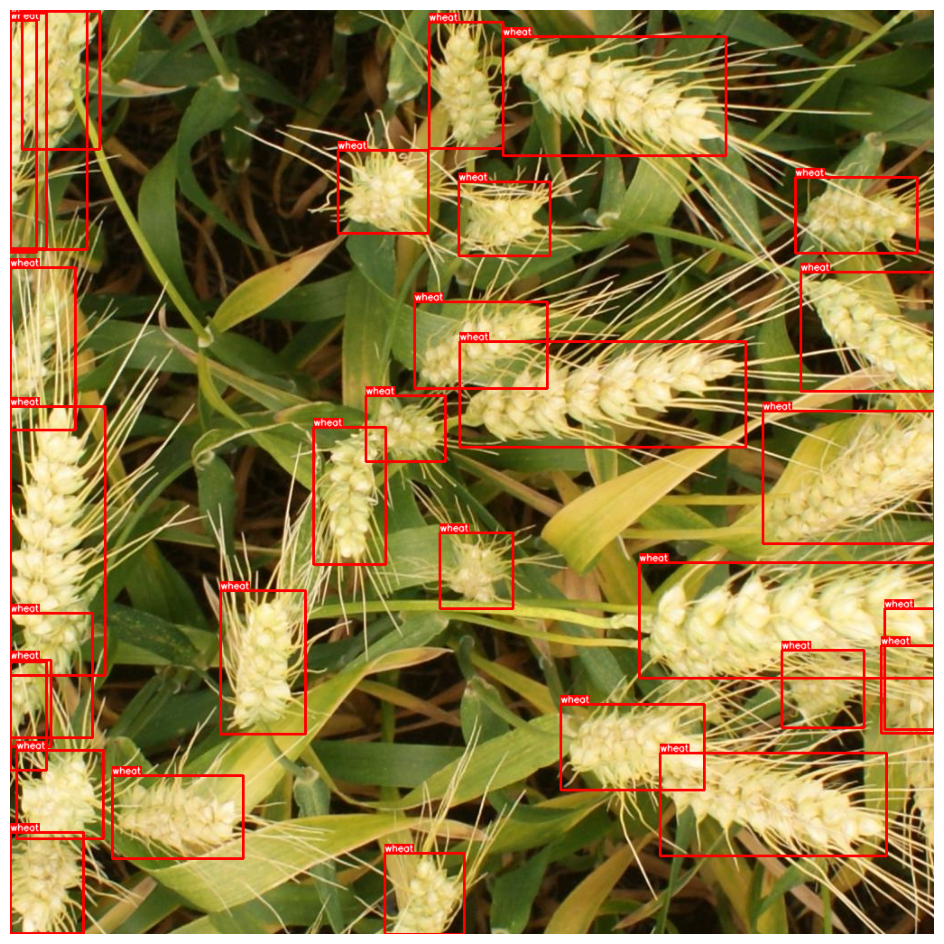

In [66]:
visualize(image, results_boxes, category_ids, category_id_to_name)